In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout
import tensorflow as tf


from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


Once we have optimized the model, as the differences between the different dataframes (created by using different NaN imputation, usin or not PCA, and different balancing techniques) we will run the whole of them in the new NN model optimized.

### 1-Load data

In [2]:
knn_df = pd.read_csv('clean_data/withsetc/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/withsetc/minus1_imputed_df.csv')

### 2-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*OPTIMIZED FUNCTION PARAMETERS*
 - optimizer = SGD
 - hidden layers = 2
 - batch size = 16
 - units = 28
 - epochs = 40
 - learning rate = 0.1
 - dropout rate: 0.3

*Optimization and cost for the model*
- loss - binary_crossentropy
- metrics - "accurancy"  

We will run each df 10 times to evaluate the dispersion of the results
In order to keep all the results we will save them in a df

In [3]:
# Create a df to save the results
data = {
    "Model": 'NN_opt',
    "Method": [],
    "mean_precision": [],
    "mean_recall": [],
    "stdev_precision": [],
    "stdev_recall": []
}

df_opt_results = pd.DataFrame(data)


In [4]:
def run_function_10_times(df, function):
        precision = []
        recall = []
        for i in range(10):   
                y_test, y_pred = function(df)
                prec= precision_score(y_test, y_pred)
                rec = recall_score(y_test, y_pred)
                precision.append(prec)
                recall.append(rec)
        return np.mean(precision), np.mean(recall), np.std(precision), np.std(recall)

In [5]:
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,...,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
7473,151529.0,54.0,1,3,30.653994,1,34.0,29.411765,0.856079,1.9,...,45.0,-0.007541,5.4,22.222222,-0.11067,93.0,0.0,0.037498,6,1


In [13]:
def NN_opt_model(df):
    """
    Builds and trains a basic neural network model for binary classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.

    Returns:
        float: F1-score on the test set.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
 
    precision = precision_score(y_test, y_pred_binary)
    print(f"precision on test set: {precision:.2f}")
    recall = recall_score(y_test, y_pred_binary)
    print(f"recall on test set: {recall:.2f}")

    return y_test, y_pred_binary

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [15]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_opt_model)

Epoch 1/40
600/600 [==============================] - 1s 857us/step - loss: 0.3701 - accuracy: 0.8568
Epoch 2/40
600/600 [==============================] - 0s 828us/step - loss: 0.3351 - accuracy: 0.8631
Epoch 3/40
600/600 [==============================] - 1s 831us/step - loss: 0.3219 - accuracy: 0.8634
Epoch 4/40
600/600 [==============================] - 1s 850us/step - loss: 0.3166 - accuracy: 0.8687
Epoch 5/40
600/600 [==============================] - 1s 954us/step - loss: 0.3149 - accuracy: 0.8676
Epoch 6/40
600/600 [==============================] - 0s 827us/step - loss: 0.3084 - accuracy: 0.8711
Epoch 7/40
600/600 [==============================] - 1s 832us/step - loss: 0.3082 - accuracy: 0.8691
Epoch 8/40
600/600 [==============================] - 1s 988us/step - loss: 0.3060 - accuracy: 0.8717
Epoch 9/40
600/600 [==============================] - 1s 862us/step - loss: 0.3036 - accuracy: 0.8715
Epoch 10/40
600/600 [==============================] - 1s 982us/step - loss: 0.297

In [16]:
print(f"basic_NN for Knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "knn_df"
df_opt_results.loc[0] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN for Knn_df : mean_prec = 0.57449592298027, mean_rec =  0.30513595166163143, stdev_prec = 0.03680702169484895, stdev_recall = 0.06064912356460644


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649


In [17]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_opt_model)

Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3776 - accuracy: 0.8533
Epoch 2/40
600/600 [==============================] - 1s 899us/step - loss: 0.3401 - accuracy: 0.8590
Epoch 3/40
600/600 [==============================] - 1s 931us/step - loss: 0.3320 - accuracy: 0.8602
Epoch 4/40
600/600 [==============================] - 1s 981us/step - loss: 0.3244 - accuracy: 0.8630
Epoch 5/40
600/600 [==============================] - 1s 916us/step - loss: 0.3219 - accuracy: 0.8625
Epoch 6/40
600/600 [==============================] - 1s 906us/step - loss: 0.3173 - accuracy: 0.8633
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3176 - accuracy: 0.8647
Epoch 8/40
600/600 [==============================] - 1s 912us/step - loss: 0.3110 - accuracy: 0.8648
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3091 - accuracy: 0.8691
Epoch 10/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3124 - accu

In [18]:
print(f"basic_NN for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "m1_df"
df_opt_results.loc[1] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN for m1_df : mean_prec = 0.5474420049096796, mean_rec =  0.28700906344410876, stdev_prec = 0.01877672169051523, stdev_recall = 0.03320515205808842


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [19]:
def NN_PCA_opt_model(df):
    """
    Builds and trains an improved neural network model for binary classification using PCA.

    Args:
        Data frame.

    Returns:
        Predicted value and real test value.
    """
        # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return y_test, y_pred_binary



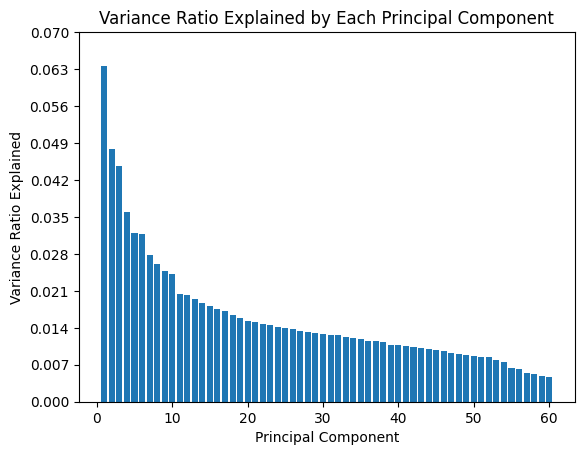

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3619 - accuracy: 0.8557
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3368 - accuracy: 0.8622
Epoch 3/40
600/600 [==============================] - 1s 916us/step - loss: 0.3316 - accuracy: 0.8609
Epoch 4/40
600/600 [==============================] - 1s 920us/step - loss: 0.3201 - accuracy: 0.8675
Epoch 5/40
600/600 [==============================] - 1s 935us/step - loss: 0.3177 - accuracy: 0.8666
Epoch 6/40
600/600 [==============================] - 1s 918us/step - loss: 0.3185 - accuracy: 0.8642
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3161 - accuracy: 0.8660
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3087 - accuracy: 0.8681
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3086 - accuracy: 0.8687
Epoch 10/40
600/600 [==

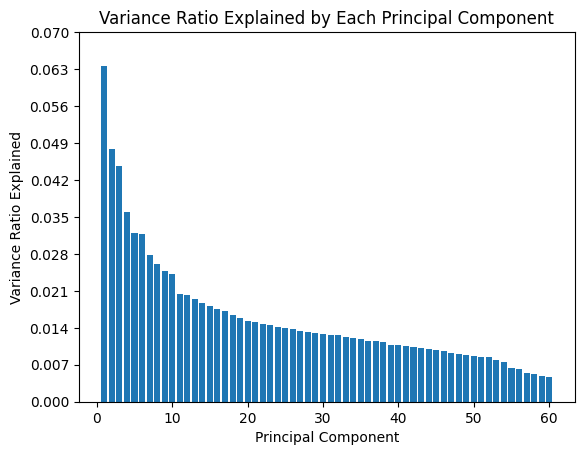

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 900us/step - loss: 0.3721 - accuracy: 0.8548
Epoch 2/40
600/600 [==============================] - 1s 988us/step - loss: 0.3354 - accuracy: 0.8608
Epoch 3/40
600/600 [==============================] - 1s 896us/step - loss: 0.3325 - accuracy: 0.8609
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3228 - accuracy: 0.8653
Epoch 5/40
600/600 [==============================] - 1s 882us/step - loss: 0.3181 - accuracy: 0.8652
Epoch 6/40
600/600 [==============================] - 1s 886us/step - loss: 0.3189 - accuracy: 0.8630
Epoch 7/40
600/600 [==============================] - 1s 934us/step - loss: 0.3167 - accuracy: 0.8681
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3110 - accuracy: 0.8709
Epoch 9/40
600/600 [==============================] - 1s 954us/step - loss: 0.3077 - accuracy: 0.8672
Epoch 10/40
600/6

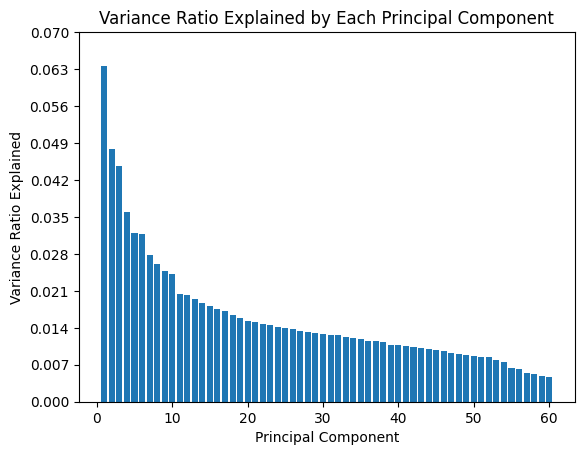

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 947us/step - loss: 0.3751 - accuracy: 0.8550
Epoch 2/40
600/600 [==============================] - 1s 953us/step - loss: 0.3330 - accuracy: 0.8630
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3236 - accuracy: 0.8626
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3201 - accuracy: 0.8644
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3167 - accuracy: 0.8667
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3109 - accuracy: 0.8667
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3111 - accuracy: 0.8674
Epoch 8/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3092 - accuracy: 0.8684
Epoch 9/40
600/600 [==============================] - 1s 970us/step - loss: 0.3073 - accuracy: 0.8704
Epoch 10/40
600/600 [====

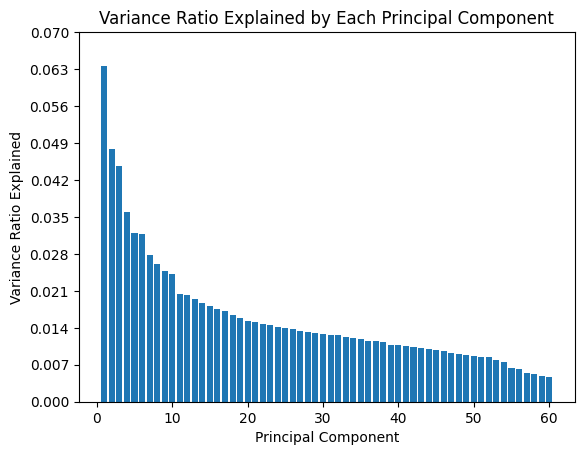

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3627 - accuracy: 0.8554
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3387 - accuracy: 0.8599
Epoch 3/40
600/600 [==============================] - 1s 925us/step - loss: 0.3233 - accuracy: 0.8643
Epoch 4/40
600/600 [==============================] - 1s 919us/step - loss: 0.3198 - accuracy: 0.8653
Epoch 5/40
600/600 [==============================] - 1s 933us/step - loss: 0.3215 - accuracy: 0.8648
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3153 - accuracy: 0.8659
Epoch 7/40
600/600 [==============================] - 1s 928us/step - loss: 0.3145 - accuracy: 0.8654
Epoch 8/40
600/600 [==============================] - 1s 984us/step - loss: 0.3097 - accuracy: 0.8691
Epoch 9/40
600/600 [==============================] - 1s 976us/step - loss: 0.3099 - accuracy: 0.8692
Epoch 10/40
600/600

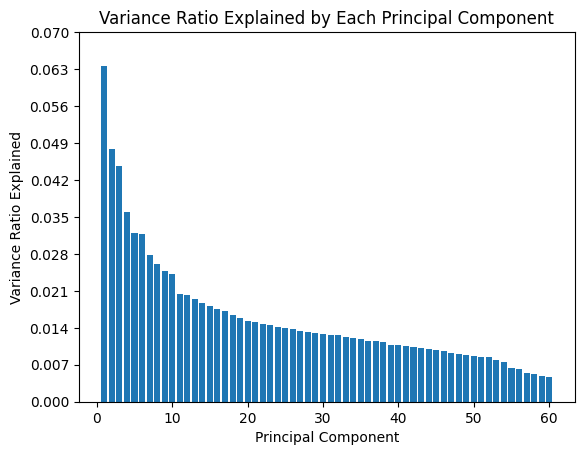

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3702 - accuracy: 0.8548
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3353 - accuracy: 0.8625
Epoch 3/40
600/600 [==============================] - 1s 936us/step - loss: 0.3279 - accuracy: 0.8631
Epoch 4/40
600/600 [==============================] - 1s 870us/step - loss: 0.3196 - accuracy: 0.8640
Epoch 5/40
600/600 [==============================] - 1s 962us/step - loss: 0.3207 - accuracy: 0.8645
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3176 - accuracy: 0.8640
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3165 - accuracy: 0.8658
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3054 - accuracy: 0.8690
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3094 - accuracy: 0.8695
Epoch 10/40
600/600 [====

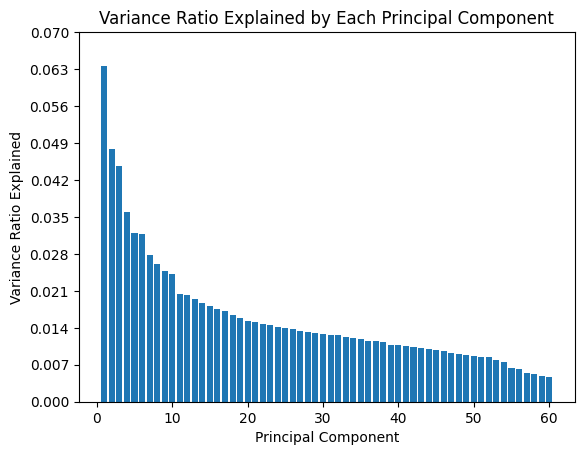

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3755 - accuracy: 0.8510
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3329 - accuracy: 0.8611
Epoch 3/40
600/600 [==============================] - 1s 933us/step - loss: 0.3272 - accuracy: 0.8603
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3209 - accuracy: 0.8653
Epoch 5/40
600/600 [==============================] - 1s 942us/step - loss: 0.3202 - accuracy: 0.8653
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3107 - accuracy: 0.8676
Epoch 7/40
600/600 [==============================] - 1s 919us/step - loss: 0.3109 - accuracy: 0.8700
Epoch 8/40
600/600 [==============================] - 1s 897us/step - loss: 0.3105 - accuracy: 0.8715
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3076 - accuracy: 0.8714
Epoch 10/40
600/600 [==

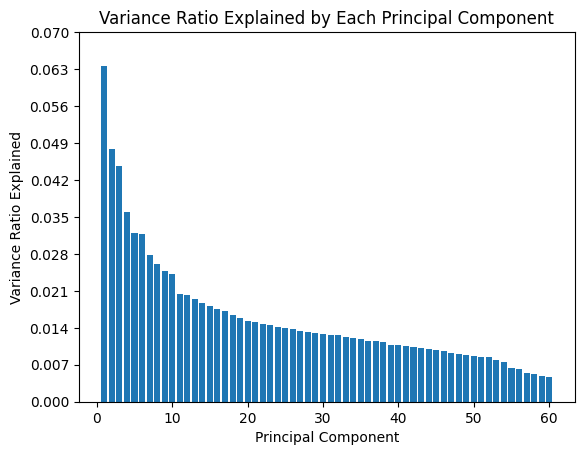

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 926us/step - loss: 0.3728 - accuracy: 0.8511
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3331 - accuracy: 0.8620
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3284 - accuracy: 0.8640
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3204 - accuracy: 0.8622
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3219 - accuracy: 0.8648
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3185 - accuracy: 0.8647
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3151 - accuracy: 0.8678
Epoch 8/40
600/600 [==============================] - 1s 943us/step - loss: 0.3116 - accuracy: 0.8697
Epoch 9/40
600/600 [==============================] - 1s 917us/step - loss: 0.3123 - accuracy: 0.8670
Epoch 10/40
600/600 [====

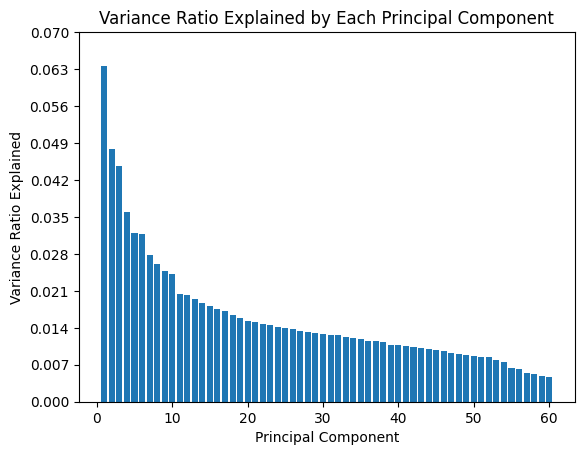

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 967us/step - loss: 0.3706 - accuracy: 0.8543
Epoch 2/40
600/600 [==============================] - 1s 988us/step - loss: 0.3377 - accuracy: 0.8608
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3302 - accuracy: 0.8648
Epoch 4/40
600/600 [==============================] - 1s 958us/step - loss: 0.3219 - accuracy: 0.8647
Epoch 5/40
600/600 [==============================] - 1s 957us/step - loss: 0.3199 - accuracy: 0.8623
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3153 - accuracy: 0.8680
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3137 - accuracy: 0.8693
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3108 - accuracy: 0.8640
Epoch 9/40
600/600 [==============================] - 1s 997us/step - loss: 0.3073 - accuracy: 0.8678
Epoch 10/40
600/600 [

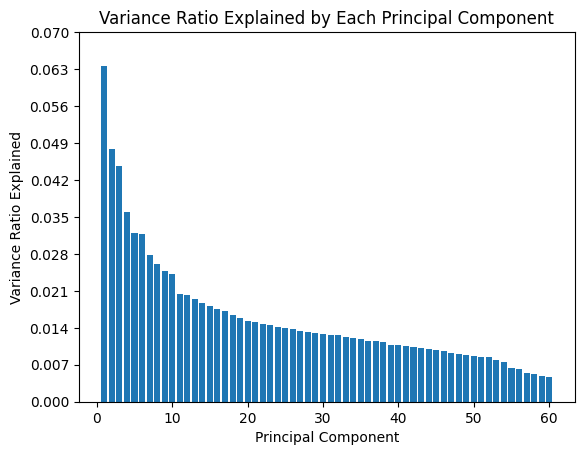

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3741 - accuracy: 0.8539
Epoch 2/40
600/600 [==============================] - 1s 967us/step - loss: 0.3346 - accuracy: 0.8604
Epoch 3/40
600/600 [==============================] - 1s 963us/step - loss: 0.3291 - accuracy: 0.8634
Epoch 4/40
600/600 [==============================] - 1s 865us/step - loss: 0.3212 - accuracy: 0.8629
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3233 - accuracy: 0.8656
Epoch 6/40
600/600 [==============================] - 1s 870us/step - loss: 0.3158 - accuracy: 0.8679
Epoch 7/40
600/600 [==============================] - 1s 931us/step - loss: 0.3141 - accuracy: 0.8665
Epoch 8/40
600/600 [==============================] - 1s 923us/step - loss: 0.3110 - accuracy: 0.8679
Epoch 9/40
600/600 [==============================] - 1s 940us/step - loss: 0.3089 - accuracy: 0.8680
Epoch 10/40
600/6

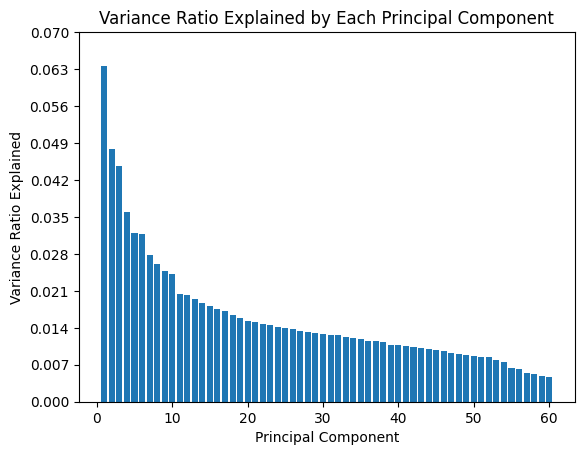

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 965us/step - loss: 0.3767 - accuracy: 0.8553
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3409 - accuracy: 0.8604
Epoch 3/40
600/600 [==============================] - 1s 962us/step - loss: 0.3267 - accuracy: 0.8611
Epoch 4/40
600/600 [==============================] - 1s 948us/step - loss: 0.3222 - accuracy: 0.8637
Epoch 5/40
600/600 [==============================] - 1s 941us/step - loss: 0.3203 - accuracy: 0.8648
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3204 - accuracy: 0.8658
Epoch 7/40
600/600 [==============================] - 1s 868us/step - loss: 0.3150 - accuracy: 0.8667
Epoch 8/40
600/600 [==============================] - 1s 944us/step - loss: 0.3119 - accuracy: 0.8700
Epoch 9/40
600/600 [==============================] - 1s 943us/step - loss: 0.3145 - accuracy: 0.8641
Epoch 10/40
600/6

In [20]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_PCA_opt_model)

In [21]:
print(f"basic_NN_PCA for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "PCA_knn_df"
df_opt_results.loc[2] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_PCA for knn_df : mean_prec = 0.5759963118840676, mean_rec =  0.2764350453172205, stdev_prec = 0.02258317450397693, stdev_recall = 0.05503550010122732


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036


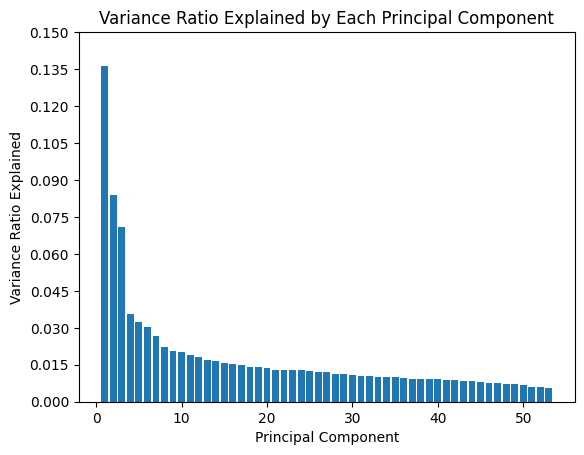

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 895us/step - loss: 0.3742 - accuracy: 0.8536
Epoch 2/40
600/600 [==============================] - 1s 912us/step - loss: 0.3439 - accuracy: 0.8596
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3374 - accuracy: 0.8584
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3303 - accuracy: 0.8607
Epoch 5/40
600/600 [==============================] - 1s 924us/step - loss: 0.3299 - accuracy: 0.8606
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3259 - accuracy: 0.8628
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3213 - accuracy: 0.8665
Epoch 8/40
600/600 [==============================] - 1s 940us/step - loss: 0.3251 - accuracy: 0.8635
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3243 - accuracy: 0.8612
Epoch 10/40
600/600 [==

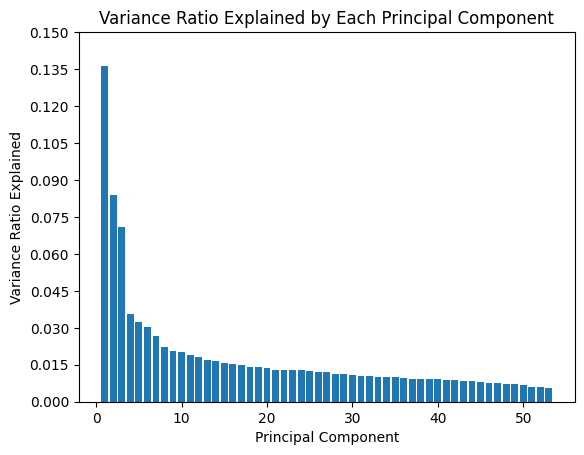

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3807 - accuracy: 0.8532
Epoch 2/40
600/600 [==============================] - 1s 906us/step - loss: 0.3469 - accuracy: 0.8581
Epoch 3/40
600/600 [==============================] - 1s 969us/step - loss: 0.3385 - accuracy: 0.8600
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3293 - accuracy: 0.8597
Epoch 5/40
600/600 [==============================] - 1s 963us/step - loss: 0.3279 - accuracy: 0.8643
Epoch 6/40
600/600 [==============================] - 1s 941us/step - loss: 0.3244 - accuracy: 0.8606
Epoch 7/40
600/600 [==============================] - 1s 938us/step - loss: 0.3212 - accuracy: 0.8623
Epoch 8/40
600/600 [==============================] - 1s 906us/step - loss: 0.3179 - accuracy: 0.8654
Epoch 9/40
600/600 [==============================] - 1s 916us/step - loss: 0.3175 - accuracy: 0.8666
Epoch 10/40
600/6

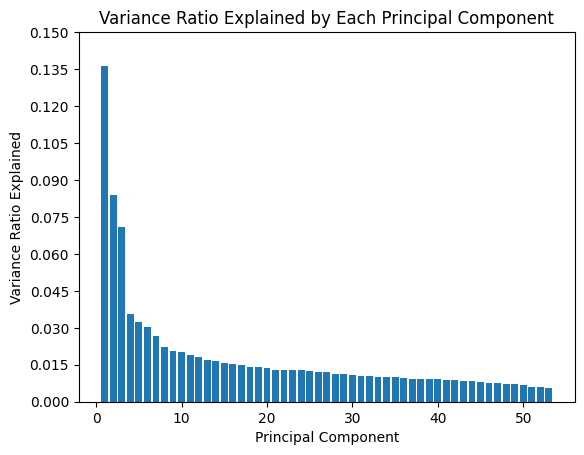

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 993us/step - loss: 0.3763 - accuracy: 0.8560
Epoch 2/40
600/600 [==============================] - 1s 951us/step - loss: 0.3423 - accuracy: 0.8615
Epoch 3/40
600/600 [==============================] - 1s 980us/step - loss: 0.3375 - accuracy: 0.8589
Epoch 4/40
600/600 [==============================] - 1s 956us/step - loss: 0.3332 - accuracy: 0.8600
Epoch 5/40
600/600 [==============================] - 1s 983us/step - loss: 0.3266 - accuracy: 0.8629
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3246 - accuracy: 0.8634
Epoch 7/40
600/600 [==============================] - 1s 875us/step - loss: 0.3249 - accuracy: 0.8617
Epoch 8/40
600/600 [==============================] - 1s 868us/step - loss: 0.3195 - accuracy: 0.8683
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3199 - accuracy: 0.8655
Epoch 10/40
600/6

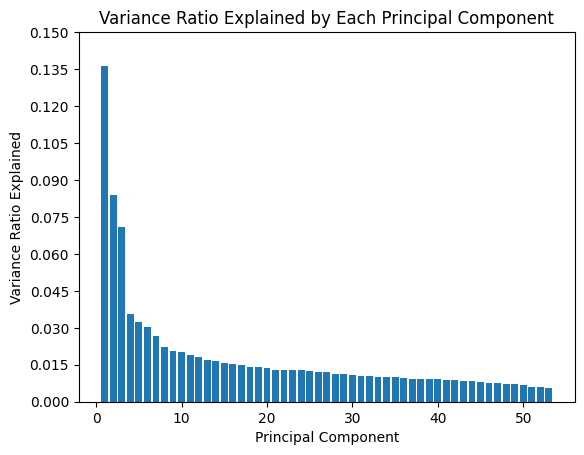

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3753 - accuracy: 0.8530
Epoch 2/40
600/600 [==============================] - 1s 905us/step - loss: 0.3426 - accuracy: 0.8564
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3370 - accuracy: 0.8611
Epoch 4/40
600/600 [==============================] - 1s 930us/step - loss: 0.3355 - accuracy: 0.8601
Epoch 5/40
600/600 [==============================] - 1s 913us/step - loss: 0.3313 - accuracy: 0.8621
Epoch 6/40
600/600 [==============================] - 1s 986us/step - loss: 0.3312 - accuracy: 0.8596
Epoch 7/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3263 - accuracy: 0.8658
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3226 - accuracy: 0.8636
Epoch 9/40
600/600 [==============================] - 1s 915us/step - loss: 0.3193 - accuracy: 0.8637
Epoch 10/40
600/600 [

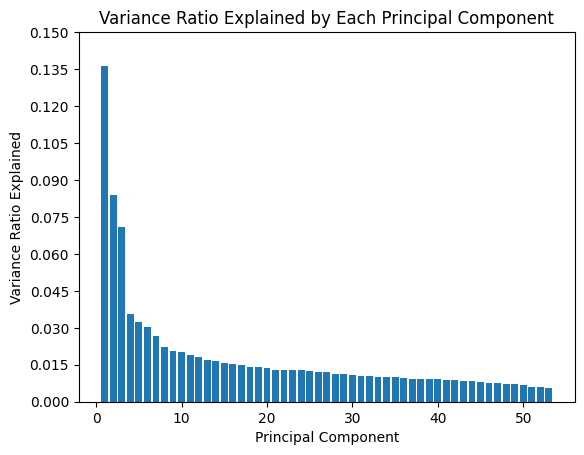

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 886us/step - loss: 0.3833 - accuracy: 0.8525
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3439 - accuracy: 0.8597
Epoch 3/40
600/600 [==============================] - 1s 952us/step - loss: 0.3361 - accuracy: 0.8596
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3303 - accuracy: 0.8614
Epoch 5/40
600/600 [==============================] - 1s 991us/step - loss: 0.3249 - accuracy: 0.8617
Epoch 6/40
600/600 [==============================] - 1s 926us/step - loss: 0.3222 - accuracy: 0.8631
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3211 - accuracy: 0.8653
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3210 - accuracy: 0.8615
Epoch 9/40
600/600 [==============================] - 1s 876us/step - loss: 0.3182 - accuracy: 0.8631
Epoch 10/40
600/600 [

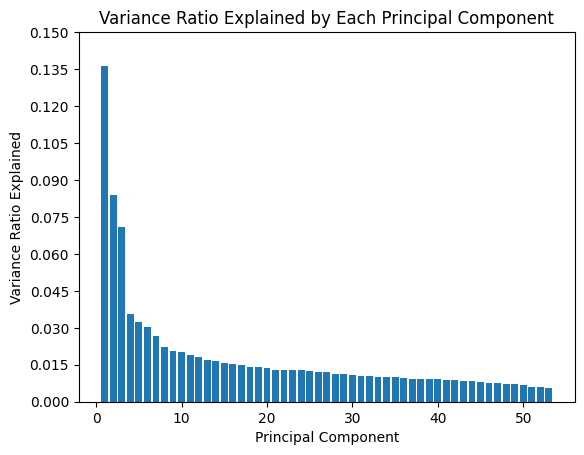

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3774 - accuracy: 0.8529
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3437 - accuracy: 0.8579
Epoch 3/40
600/600 [==============================] - 1s 984us/step - loss: 0.3408 - accuracy: 0.8579
Epoch 4/40
600/600 [==============================] - 1s 987us/step - loss: 0.3348 - accuracy: 0.8592
Epoch 5/40
600/600 [==============================] - 1s 903us/step - loss: 0.3283 - accuracy: 0.8591
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3295 - accuracy: 0.8627
Epoch 7/40
600/600 [==============================] - 1s 985us/step - loss: 0.3257 - accuracy: 0.8615
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3206 - accuracy: 0.8651
Epoch 9/40
600/600 [==============================] - 1s 936us/step - loss: 0.3226 - accuracy: 0.8668
Epoch 10/40
600/600 [

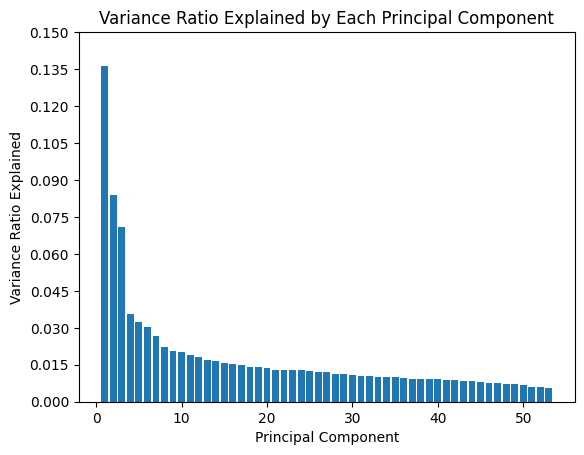

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 945us/step - loss: 0.3781 - accuracy: 0.8540
Epoch 2/40
600/600 [==============================] - 1s 900us/step - loss: 0.3437 - accuracy: 0.8612
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3382 - accuracy: 0.8606
Epoch 4/40
600/600 [==============================] - 1s 904us/step - loss: 0.3284 - accuracy: 0.8633
Epoch 5/40
600/600 [==============================] - 1s 925us/step - loss: 0.3297 - accuracy: 0.8620
Epoch 6/40
600/600 [==============================] - 1s 866us/step - loss: 0.3283 - accuracy: 0.8647
Epoch 7/40
600/600 [==============================] - 1s 961us/step - loss: 0.3259 - accuracy: 0.8647
Epoch 8/40
600/600 [==============================] - 1s 950us/step - loss: 0.3235 - accuracy: 0.8653
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3200 - accuracy: 0.8647
Epoch 10/40
600/6

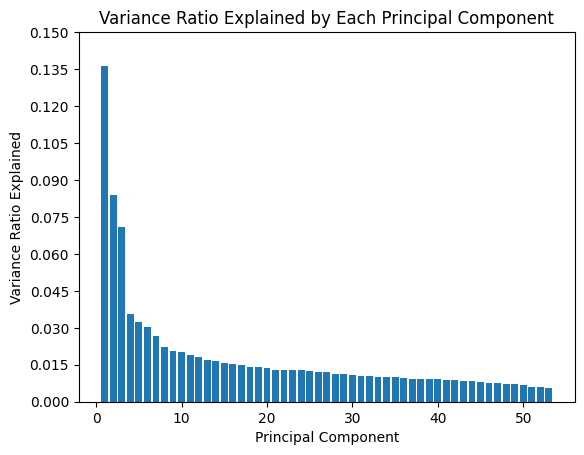

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 922us/step - loss: 0.3778 - accuracy: 0.8524
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3429 - accuracy: 0.8602
Epoch 3/40
600/600 [==============================] - 1s 923us/step - loss: 0.3362 - accuracy: 0.8586
Epoch 4/40
600/600 [==============================] - 1s 994us/step - loss: 0.3293 - accuracy: 0.8627
Epoch 5/40
600/600 [==============================] - 1s 929us/step - loss: 0.3306 - accuracy: 0.8615
Epoch 6/40
600/600 [==============================] - 1s 997us/step - loss: 0.3224 - accuracy: 0.8646
Epoch 7/40
600/600 [==============================] - 1s 948us/step - loss: 0.3243 - accuracy: 0.8634
Epoch 8/40
600/600 [==============================] - 1s 971us/step - loss: 0.3179 - accuracy: 0.8656
Epoch 9/40
600/600 [==============================] - 1s 986us/step - loss: 0.3203 - accuracy: 0.8652
Epoch 10/40
600

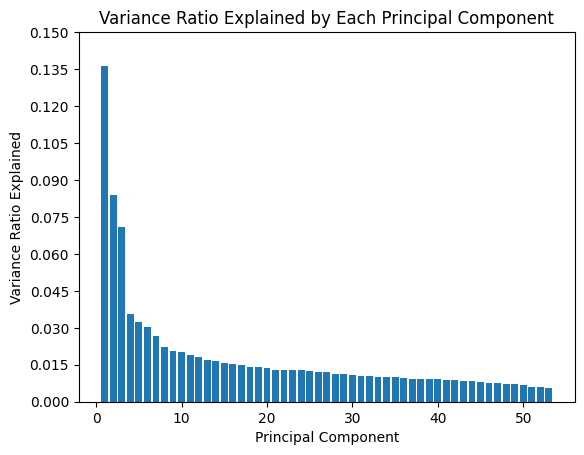

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 940us/step - loss: 0.3794 - accuracy: 0.8521
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3471 - accuracy: 0.8565
Epoch 3/40
600/600 [==============================] - 1s 944us/step - loss: 0.3366 - accuracy: 0.8576
Epoch 4/40
600/600 [==============================] - 1s 951us/step - loss: 0.3348 - accuracy: 0.8617
Epoch 5/40
600/600 [==============================] - 1s 987us/step - loss: 0.3302 - accuracy: 0.8619
Epoch 6/40
600/600 [==============================] - 1s 862us/step - loss: 0.3304 - accuracy: 0.8616
Epoch 7/40
600/600 [==============================] - 1s 904us/step - loss: 0.3271 - accuracy: 0.8626
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3244 - accuracy: 0.8653
Epoch 9/40
600/600 [==============================] - 1s 877us/step - loss: 0.3192 - accuracy: 0.8650
Epoch 10/40
600/6

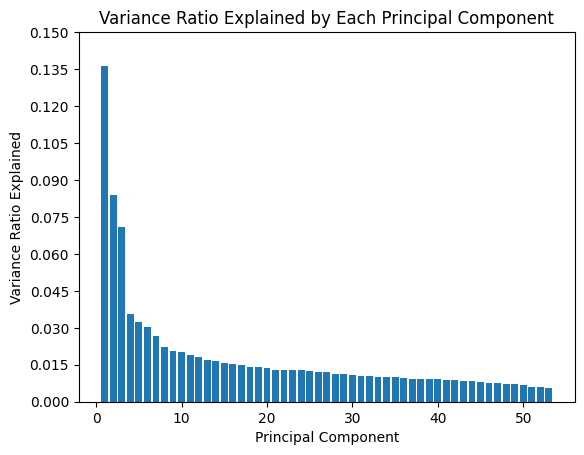

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/40
600/600 [==============================] - 1s 989us/step - loss: 0.3825 - accuracy: 0.8552
Epoch 2/40
600/600 [==============================] - 1s 914us/step - loss: 0.3460 - accuracy: 0.8625
Epoch 3/40
600/600 [==============================] - 1s 949us/step - loss: 0.3404 - accuracy: 0.8602
Epoch 4/40
600/600 [==============================] - 1s 941us/step - loss: 0.3334 - accuracy: 0.8595
Epoch 5/40
600/600 [==============================] - 1s 961us/step - loss: 0.3328 - accuracy: 0.8597
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3284 - accuracy: 0.8617
Epoch 7/40
600/600 [==============================] - 1s 996us/step - loss: 0.3243 - accuracy: 0.8607
Epoch 8/40
600/600 [==============================] - 1s 980us/step - loss: 0.3238 - accuracy: 0.8650
Epoch 9/40
600/600 [==============================] - 1s 898us/step - loss: 0.3230 - accuracy: 0.8615
Epoch 10/40
600

In [22]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_PCA_opt_model)

In [23]:
print(f"basic_NN_PCA for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "PCA_m1_df"
df_opt_results.loc[3] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_PCA for m1_df : mean_prec = 0.5627953657430173, mean_rec =  0.2226586102719033, stdev_prec = 0.04439757043410182, stdev_recall = 0.05114670678860292


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147


**3.4 -Managing the inbalance problem.**

Balancing the initial dataframes with two different methods:

 - SOMTE
 - RandomOverSampler
 - RandomUnderSampler

In [26]:
def NN_Balanced_opt_model(df, method):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data balancing
    met = method(random_state=42)
    X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

 # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return  y_test,y_pred_binary

as now we are using a function (NN_Balanced_model) that requiers an extra argument from run_10_times function we must use a labmda function to be able to pass this extra argument.

In [27]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_opt_model(knn_df, method=SMOTE))

Epoch 1/40
1028/1028 [==============================] - 1s 920us/step - loss: 0.5091 - accuracy: 0.7519
Epoch 2/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4527 - accuracy: 0.7934
Epoch 3/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4354 - accuracy: 0.8032
Epoch 4/40
1028/1028 [==============================] - 1s 969us/step - loss: 0.4231 - accuracy: 0.8120
Epoch 5/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4125 - accuracy: 0.8157
Epoch 6/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4053 - accuracy: 0.8199
Epoch 7/40
1028/1028 [==============================] - 1s 881us/step - loss: 0.3994 - accuracy: 0.8264
Epoch 8/40
1028/1028 [==============================] - 1s 979us/step - loss: 0.3895 - accuracy: 0.8266
Epoch 9/40
1028/1028 [==============================] - 1s 908us/step - loss: 0.3912 - accuracy: 0.8282
Epoch 10/40
1028/1028 [==============================] - 1s 915us/step -

In [28]:
print(f"basic_NN_smote for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "Smote_knn_df"
df_opt_results.loc[4] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_smote for knn_df : mean_prec = 0.34787732607283706, mean_rec =  0.5401812688821752, stdev_prec = 0.016356799804388162, stdev_recall = 0.04187969414178477


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147
4,NN_opt,Smote_knn_df,0.347877,0.540181,0.016357,0.041880


In [29]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_opt_model(m1_df, method=SMOTE))

Epoch 1/40
1028/1028 [==============================] - 2s 1ms/step - loss: 0.5127 - accuracy: 0.7574
Epoch 2/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4640 - accuracy: 0.7857
Epoch 3/40
1028/1028 [==============================] - 1s 892us/step - loss: 0.4432 - accuracy: 0.7990
Epoch 4/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4322 - accuracy: 0.8012
Epoch 5/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4212 - accuracy: 0.8105
Epoch 6/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4141 - accuracy: 0.8151
Epoch 7/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4124 - accuracy: 0.8154
Epoch 8/40
1028/1028 [==============================] - 1s 979us/step - loss: 0.4023 - accuracy: 0.8209
Epoch 9/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4043 - accuracy: 0.8223
Epoch 10/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0

In [30]:
print(f"basic_NN_smote for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "Smote_m1_df"
df_opt_results.loc[5] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_smote for m1_df : mean_prec = 0.34369517019591134, mean_rec =  0.5444108761329305, stdev_prec = 0.023165680910120393, stdev_recall = 0.04880440001524754


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147
4,NN_opt,Smote_knn_df,0.347877,0.540181,0.016357,0.041880
5,NN_opt,Smote_m1_df,0.343695,0.544411,0.023166,0.048804


In [31]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_opt_model(knn_df, method=RandomOverSampler))

Epoch 1/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5471 - accuracy: 0.7274
Epoch 2/40
1028/1028 [==============================] - 1s 931us/step - loss: 0.4958 - accuracy: 0.7641
Epoch 3/40
1028/1028 [==============================] - 1s 911us/step - loss: 0.4812 - accuracy: 0.7755
Epoch 4/40
1028/1028 [==============================] - 1s 898us/step - loss: 0.4694 - accuracy: 0.7811
Epoch 5/40
1028/1028 [==============================] - 1s 948us/step - loss: 0.4539 - accuracy: 0.7888
Epoch 6/40
1028/1028 [==============================] - 1s 979us/step - loss: 0.4516 - accuracy: 0.7927
Epoch 7/40
1028/1028 [==============================] - 1s 883us/step - loss: 0.4426 - accuracy: 0.7989
Epoch 8/40
1028/1028 [==============================] - 1s 895us/step - loss: 0.4355 - accuracy: 0.8014
Epoch 9/40
1028/1028 [==============================] - 1s 947us/step - loss: 0.4302 - accuracy: 0.8027
Epoch 10/40
1028/1028 [==============================] - 1s 902us/

In [32]:
print(f"basic_NN_ros for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "ros_knn_df"
df_opt_results.loc[6] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_ros for knn_df : mean_prec = 0.34194796411130624, mean_rec =  0.7042296072507552, stdev_prec = 0.01501025911358324, stdev_recall = 0.02902346962929903


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147
4,NN_opt,Smote_knn_df,0.347877,0.540181,0.016357,0.041880
5,NN_opt,Smote_m1_df,0.343695,0.544411,0.023166,0.048804
6,NN_opt,ros_knn_df,0.341948,0.704230,0.015010,0.029023


In [33]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_opt_model(m1_df, method=RandomOverSampler))

Epoch 1/40
1028/1028 [==============================] - 1s 858us/step - loss: 0.5597 - accuracy: 0.7105
Epoch 2/40
1028/1028 [==============================] - 1s 853us/step - loss: 0.5026 - accuracy: 0.7592
Epoch 3/40
1028/1028 [==============================] - 1s 863us/step - loss: 0.4878 - accuracy: 0.7647
Epoch 4/40
1028/1028 [==============================] - 1s 838us/step - loss: 0.4777 - accuracy: 0.7749
Epoch 5/40
1028/1028 [==============================] - 1s 917us/step - loss: 0.4726 - accuracy: 0.7763
Epoch 6/40
1028/1028 [==============================] - 1s 819us/step - loss: 0.4611 - accuracy: 0.7862
Epoch 7/40
1028/1028 [==============================] - 1s 824us/step - loss: 0.4536 - accuracy: 0.7871
Epoch 8/40
1028/1028 [==============================] - 1s 828us/step - loss: 0.4456 - accuracy: 0.7938
Epoch 9/40
1028/1028 [==============================] - 1s 919us/step - loss: 0.4446 - accuracy: 0.7961
Epoch 10/40
1028/1028 [==============================] - 1s 835u

In [34]:
print(f"basic_NN_ros for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "ros_m1_df"
df_opt_results.loc[7] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_ros for m1_df : mean_prec = 0.34058505470910305, mean_rec =  0.6861027190332326, stdev_prec = 0.00887571725771375, stdev_recall = 0.027272450685401822


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147
4,NN_opt,Smote_knn_df,0.347877,0.540181,0.016357,0.041880
5,NN_opt,Smote_m1_df,0.343695,0.544411,0.023166,0.048804
6,NN_opt,ros_knn_df,0.341948,0.704230,0.015010,0.029023
7,NN_opt,ros_m1_df,0.340585,0.686103,0.008876,0.027272


In [35]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_opt_model(knn_df, method=RandomUnderSampler))

Epoch 1/40
172/172 [==============================] - 1s 957us/step - loss: 0.6241 - accuracy: 0.6577
Epoch 2/40
172/172 [==============================] - 0s 945us/step - loss: 0.5593 - accuracy: 0.7169
Epoch 3/40
172/172 [==============================] - 0s 869us/step - loss: 0.5267 - accuracy: 0.7424
Epoch 4/40
172/172 [==============================] - 0s 967us/step - loss: 0.5204 - accuracy: 0.7438
Epoch 5/40
172/172 [==============================] - 0s 891us/step - loss: 0.5021 - accuracy: 0.7580
Epoch 6/40
172/172 [==============================] - 0s 1ms/step - loss: 0.4971 - accuracy: 0.7624
Epoch 7/40
172/172 [==============================] - 0s 992us/step - loss: 0.4878 - accuracy: 0.7765
Epoch 8/40
172/172 [==============================] - 0s 956us/step - loss: 0.4761 - accuracy: 0.7758
Epoch 9/40
172/172 [==============================] - 0s 901us/step - loss: 0.4748 - accuracy: 0.7765
Epoch 10/40
172/172 [==============================] - 0s 971us/step - loss: 0.4694 

In [36]:
print(f"basic_NN_rus for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "rus_knn_df"
df_opt_results.loc[8] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_rus for knn_df : mean_prec = 0.3095141313517672, mean_rec =  0.7561933534743203, stdev_prec = 0.02161701576606589, stdev_recall = 0.039461559805866187


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147
4,NN_opt,Smote_knn_df,0.347877,0.540181,0.016357,0.041880
5,NN_opt,Smote_m1_df,0.343695,0.544411,0.023166,0.048804
6,NN_opt,ros_knn_df,0.341948,0.704230,0.015010,0.029023
7,NN_opt,ros_m1_df,0.340585,0.686103,0.008876,0.027272
8,NN_opt,rus_knn_df,0.309514,0.756193,0.021617,0.039462


In [37]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_opt_model(m1_df, method=RandomUnderSampler))

Epoch 1/40
172/172 [==============================] - 1s 997us/step - loss: 0.6391 - accuracy: 0.6523
Epoch 2/40
172/172 [==============================] - 0s 936us/step - loss: 0.5624 - accuracy: 0.7144
Epoch 3/40
172/172 [==============================] - 0s 918us/step - loss: 0.5477 - accuracy: 0.7373
Epoch 4/40
172/172 [==============================] - 0s 883us/step - loss: 0.5343 - accuracy: 0.7362
Epoch 5/40
172/172 [==============================] - 0s 936us/step - loss: 0.5217 - accuracy: 0.7482
Epoch 6/40
172/172 [==============================] - 0s 924us/step - loss: 0.5110 - accuracy: 0.7482
Epoch 7/40
172/172 [==============================] - 0s 918us/step - loss: 0.5032 - accuracy: 0.7631
Epoch 8/40
172/172 [==============================] - 0s 983us/step - loss: 0.4996 - accuracy: 0.7613
Epoch 9/40
172/172 [==============================] - 0s 918us/step - loss: 0.5089 - accuracy: 0.7540
Epoch 10/40
172/172 [==============================] - 0s 879us/step - loss: 0.493

In [38]:
print(f"basic_NN_rus for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "rus_m1_df"
df_opt_results.loc[9] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_rus for m1_df : mean_prec = 0.30527480902111703, mean_rec =  0.7226586102719034, stdev_prec = 0.021794337076555863, stdev_recall = 0.04991390073247949


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.574496,0.305136,0.036807,0.060649
1,NN_opt,m1_df,0.547442,0.287009,0.018777,0.033205
2,NN_opt,PCA_knn_df,0.575996,0.276435,0.022583,0.055036
3,NN_opt,PCA_m1_df,0.562795,0.222659,0.044398,0.051147
4,NN_opt,Smote_knn_df,0.347877,0.540181,0.016357,0.041880
5,NN_opt,Smote_m1_df,0.343695,0.544411,0.023166,0.048804
6,NN_opt,ros_knn_df,0.341948,0.704230,0.015010,0.029023
7,NN_opt,ros_m1_df,0.340585,0.686103,0.008876,0.027272
8,NN_opt,rus_knn_df,0.309514,0.756193,0.021617,0.039462
9,NN_opt,rus_m1_df,0.305275,0.722659,0.021794,0.049914


In [39]:
df_opt_results_12000= df_opt_results

In [40]:
df_opt_results_12000.to_csv("result_dframes/NN_optimized_12000.csv", index=False)